# Classifier Evaluation Lab (scikit-learn)

**Course level:** Senior undergraduate  
**Topic:** Evaluating binary classifiers (metrics, ROC/PR, thresholds, cross-validation)

---

## What you will learn
- How to compute and interpret a confusion matrix  
- Accuracy vs precision/recall/specificity/F1  
- ROC curve vs PR curve (and when each is appropriate)  
- How to choose a decision threshold for different real-world goals  
- How to evaluate models using stratified train/test split and cross-validation  
- How to avoid data leakage using pipelines  

---

## Deliverables
1. Completed notebook (code + answers)
2. A short recommendation: *Which model would you deploy and at what threshold?*


In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report
)

import matplotlib.pyplot as plt

np.random.seed(42)

## Part 1 — Create an imbalanced dataset

We will create a synthetic dataset with:
- **8% positives**
- **92% negatives**

This simulates many real problems (fraud, rare disease screening, defect detection).


In [3]:
# X, y = make_classification(
#     n_samples=5000,
#     n_features=20,
#     n_informative=6,
#     n_redundant=4,
#     weights=[0.92, 0.08],   # 8% positive
#     class_sep=0.1,
#     random_state=42
# )

X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=6,
    n_redundant=4,
    weights=[0.92, 0.08],   # 8% positive
    class_sep=0.1,
)

print("Total samples:", len(y))
print("Positive prevalence:", y.mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)
print(f'\nX_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'\y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

print("\nTrain prevalence:", y_train.mean())
print("Test prevalence:", y_test.mean())


Total samples: 5000
Positive prevalence: 0.0822

X_train shape: (3750, 20)
X_test shape: (1250, 20)
\y_train shape: (3750,)
y_test shape: (1250,)

Train prevalence: 0.08213333333333334
Test prevalence: 0.0824


## Part 2 — Train three models

We will train:
1. Decision Tree (no scaling needed)
1. Logistic Regression (with scaling)
2. Random Forest (no scaling needed)

**Important:** We will use a `Pipeline` for Logistic Regression to avoid leakage.


In [4]:
# decision tree training
# decision_tree_obj = DecisionTreeClassifier(random_state=42)
# decision_tree_obj = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20)
decision_tree_obj = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=20)
# decision_tree_obj = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_leaf=20)
decision_tree_obj.fit(X_train, y_train)

print(f'decision tree classes: {decision_tree_obj.classes_}')
print(f'Tree depth: {decision_tree_obj.get_depth()}')

decision tree classes: [0 1]
Tree depth: 10


In [4]:
# decision tree prediction
predicted_probability = decision_tree_obj.predict_log_proba(X_test)
print(predicted_probability.shape)
print(predicted_probability[0:5, :])

(1250, 2)
[[-0.16251893 -1.89711998]
 [ 0.                -inf]
 [-0.11332869 -2.23359222]
 [ 0.                -inf]
 [-0.11551289 -2.21557372]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/tree/_classes.py:1092: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [6]:
predicted_probability = decision_tree_obj.predict_proba(X_test)
print(predicted_probability.shape)
print(predicted_probability[0:5, :])

(1250, 2)
[[1.         0.        ]
 [0.97079683 0.02920317]
 [0.97079683 0.02920317]
 [1.         0.        ]
 [0.97079683 0.02920317]]


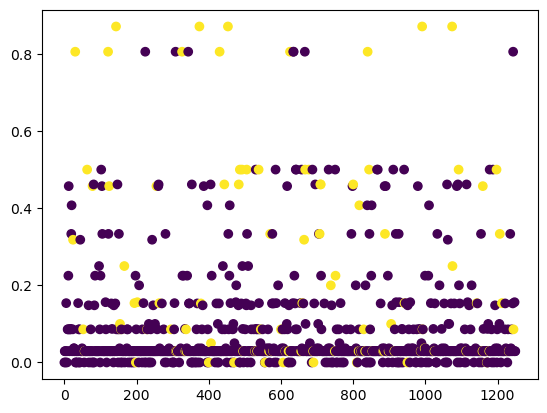

In [7]:
fig, ax = plt.subplots()
x_coordinate = list(range(len(predicted_probability)))
ax.scatter(x_coordinate, predicted_probability[:, 1], c=y_test)

In [8]:
# logistic regression
logistic_regression_obj = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

# random forest
random_forest_obj = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight=None
)

logistic_regression_obj.fit(X_train, y_train)
random_forest_obj.fit(X_train, y_train)

print("Models trained.")

Models trained.


## Part 3 — Evaluate using confusion matrix + metrics (threshold = 0.5)

Most classifiers output probabilities.

To convert probabilities to a predicted class label, we choose a threshold:

$$
\hat{y} = 1 \text{ if } \hat{p} \ge 0.5
$$

This is the default — but it is often not optimal.


In [9]:
def evaluate_at_threshold(model, X, y_true, threshold=0.5):
    y_prob = decision_tree_obj.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    contingency_table = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = contingency_table.ravel()

    results = {
        "threshold": threshold,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
    }
    return results, y_prob, y_pred, contingency_table

dt_results, dt_prob, dt_pred, dt_contingency_table = evaluate_at_threshold(decision_tree_obj, X_test, y_test, threshold=0.5)
print(dt_results)
print()
print(dt_contingency_table)

lr_results, lr_prob, lr_pred, lr_contingency_table = evaluate_at_threshold(logistic_regression_obj, X_test, y_test, threshold=0.5)
rf_results, rf_prob, rf_pred, rf_contingency_table = evaluate_at_threshold(random_forest_obj, X_test, y_test, threshold=0.5)

pd.DataFrame([dt_results, lr_results, rf_results], index=['DecisionTree', 'LogReg', 'RandForest'])


{'threshold': 0.5, 'TP': np.int64(21), 'FP': np.int64(22), 'TN': np.int64(1125), 'FN': np.int64(82), 'accuracy': 0.9168, 'precision': 0.4883720930232558, 'recall': 0.20388349514563106, 'f1': 0.2876712328767123, 'roc_auc': 0.7016911994989039, 'pr_auc': 0.2908432698577233}

[[1125   22]
 [  82   21]]


,threshold,TP,FP,TN,FN,accuracy,precision,recall,f1,roc_auc,pr_auc
DecisionTree,0.5,21,22,1125,82,0.9168,0.488372,0.203883,0.287671,0.701691,0.290843
LogReg,0.5,21,22,1125,82,0.9168,0.488372,0.203883,0.287671,0.701691,0.290843
RandForest,0.5,21,22,1125,82,0.9168,0.488372,0.203883,0.287671,0.701691,0.290843


## Part 4 — Inspect the confusion matrix

**Task:** Interpret the confusion matrix for each model.

- Which model has more false negatives?
- Which model has more false positives?
- Which error is more costly depends on the application.


In [8]:
print('Decision Tree confusion matrix:\n', dt_contingency_table)
print('\nDecision Tree report:')
print(classification_report(y_test, dt_pred))

print("Logistic Regression confusion matrix:\n", lr_contingency_table)
print("\nClassification report (LogReg):")
print(classification_report(y_test, lr_pred, digits=3))

print("\nRandom Forest confusion matrix:\n", rf_contingency_table)
print("\nClassification report (RandForest):")
print(classification_report(y_test, rf_pred, digits=3))

Decision Tree confusion matrix:
 [[1144    0]
 [ 106    0]]

Decision Tree report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1144
           1       0.00      0.00      0.00       106

    accuracy                           0.92      1250
   macro avg       0.46      0.50      0.48      1250
weighted avg       0.84      0.92      0.87      1250

Logistic Regression confusion matrix:
 [[1144    0]
 [ 106    0]]

Classification report (LogReg):
              precision    recall  f1-score   support

           0      0.915     1.000     0.956      1144
           1      0.000     0.000     0.000       106

    accuracy                          0.915      1250
   macro avg      0.458     0.500     0.478      1250
weighted avg      0.838     0.915     0.875      1250


Random Forest confusion matrix:
 [[1144    0]
 [ 106    0]]

Classification report (RandForest):
              precision    recall  f1-score   support

           

/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python

## Part 5 — ROC curve vs Precision–Recall curve

### ROC curve
- x-axis: False Positive Rate (FPR)
- y-axis: True Positive Rate (TPR = recall)

### PR curve
- x-axis: Recall
- y-axis: Precision

**Question:** Which curve is more informative for imbalanced data?


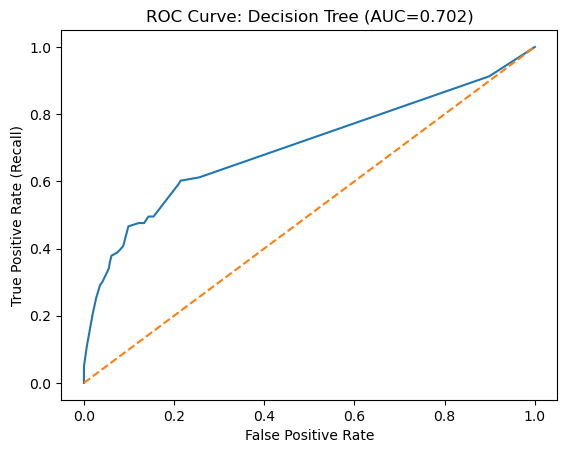

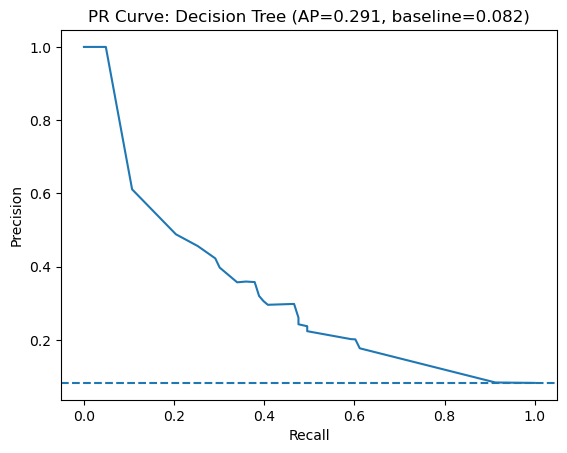

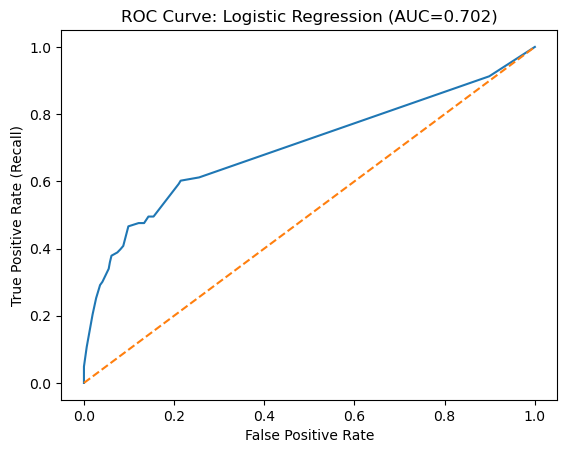

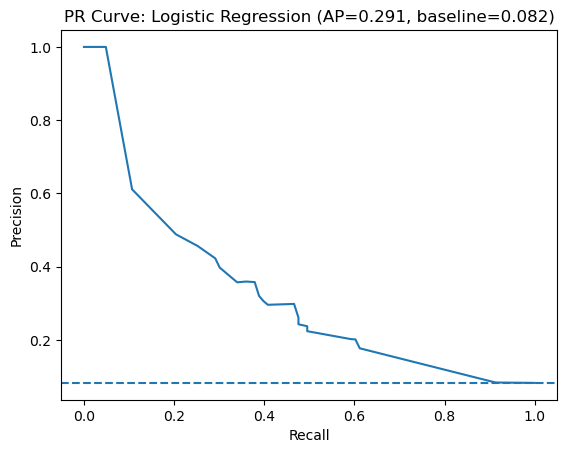

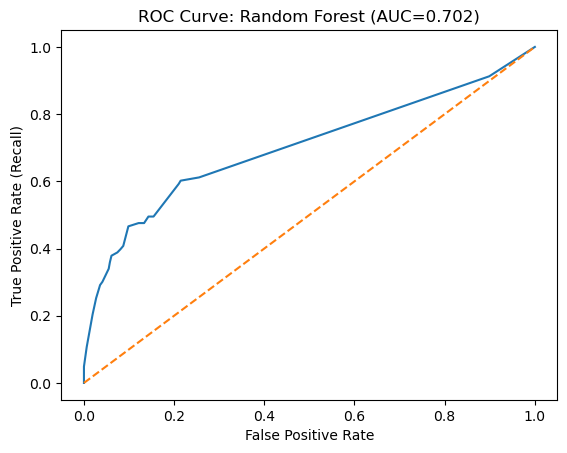

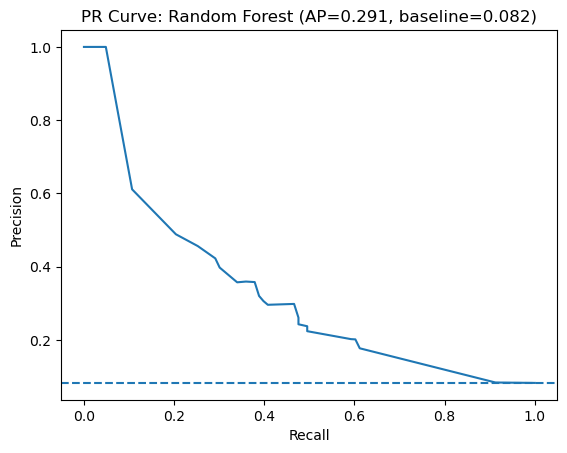

In [10]:
def plot_roc(model_name, y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve: {model_name} (AUC={auc:.3f})")
    plt.show()

def plot_pr(model_name, y_true, y_prob):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    baseline = y_true.mean()

    plt.figure()
    plt.plot(rec, prec)
    plt.axhline(baseline, linestyle="--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve: {model_name} (AP={ap:.3f}, baseline={baseline:.3f})")
    plt.show()

plot_roc('Decision Tree', y_test, decision_tree_obj.predict_proba(X_test)[:, 1])
plot_pr('Decision Tree', y_test, decision_tree_obj.predict_proba(X_test)[:, 1])

plot_roc("Logistic Regression", y_test, lr_prob)
plot_pr("Logistic Regression", y_test, lr_prob)

plot_roc("Random Forest", y_test, rf_prob)
plot_pr("Random Forest", y_test, rf_prob)


## Part 6 — Threshold tuning

The threshold controls the tradeoff between precision and recall.

- Lower threshold → predict more positives → higher recall, lower precision
- Higher threshold → predict fewer positives → higher precision, lower recall

### Task
Find thresholds for two scenarios:

**Scenario A (screening):** require recall ≥ 0.90  
**Scenario B (confirmatory):** require precision ≥ 0.80


In [14]:
def threshold_table(y_true, y_prob, thresholds):
    rows = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred)
        })
    return pd.DataFrame(rows)

thresholds = np.linspace(0.05, 0.95, 19)

dt_table = threshold_table(y_test, dt_prob, thresholds)
lr_table = threshold_table(y_test, lr_prob, thresholds)
rf_table = threshold_table(y_test, rf_prob, thresholds)

print('Decision threshold table:')
print(dt_table)

print("LogReg threshold table:")
display(lr_table)

print("\nRandForest threshold table:")
display(rf_table)


Decision threshold table:
    threshold  precision    recall        f1
0        0.05   0.123214  0.650943  0.207207
1        0.10   0.146341  0.566038  0.232558
2        0.15   0.176895  0.462264  0.255875
3        0.20   0.181818  0.339623  0.236842
4        0.25   0.174497  0.245283  0.203922
5        0.30   0.180180  0.188679  0.184332
6        0.35   0.185185  0.141509  0.160428
7        0.40   0.193548  0.113208  0.142857
8        0.45   0.186047  0.075472  0.107383
9        0.50   0.200000  0.047170  0.076336
10       0.55   0.210526  0.037736  0.064000
11       0.60   0.500000  0.018868  0.036364
12       0.65   0.500000  0.018868  0.036364
13       0.70   0.500000  0.018868  0.036364
14       0.75   0.000000  0.000000  0.000000
15       0.80   0.000000  0.000000  0.000000
16       0.85   0.000000  0.000000  0.000000
17       0.90   0.000000  0.000000  0.000000
18       0.95   0.000000  0.000000  0.000000
LogReg threshold table:


,threshold,precision,recall,f1
0,0.05,0.123214,0.650943,0.207207
1,0.10,0.146341,0.566038,0.232558
2,0.15,0.176895,0.462264,0.255875
3,0.20,0.181818,0.339623,0.236842
4,0.25,0.174497,0.245283,0.203922
5,0.30,0.180180,0.188679,0.184332
6,0.35,0.185185,0.141509,0.160428
7,0.40,0.193548,0.113208,0.142857
8,0.45,0.186047,0.075472,0.107383
9,0.50,0.200000,0.047170,0.076336



RandForest threshold table:


,threshold,precision,recall,f1
0,0.05,0.123214,0.650943,0.207207
1,0.10,0.146341,0.566038,0.232558
2,0.15,0.176895,0.462264,0.255875
3,0.20,0.181818,0.339623,0.236842
4,0.25,0.174497,0.245283,0.203922
5,0.30,0.180180,0.188679,0.184332
6,0.35,0.185185,0.141509,0.160428
7,0.40,0.193548,0.113208,0.142857
8,0.45,0.186047,0.075472,0.107383
9,0.50,0.200000,0.047170,0.076336


## Part 7 — Choose thresholds automatically

Now we will compute:

- The **lowest threshold** that achieves recall ≥ 0.90 (screening)
- The **highest threshold** that achieves precision ≥ 0.80 (confirmatory)

Do this for both models.


In [18]:
def pick_threshold_for_recall(y_true, y_prob, recall_target=0.90):
    thresholds = np.linspace(0.0, 1.0, 1001)
    best = None
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        r = recall_score(y_true, y_pred)
        p = precision_score(y_true, y_pred, zero_division=0)
        if r >= recall_target:
            # choose the highest precision among thresholds that meet recall
            if best is None or p > best["precision"]:
                best = {"threshold": t, "precision": p, "recall": r, "f1": f1_score(y_true, y_pred)}
    return best

def pick_threshold_for_precision(y_true, y_prob, precision_target=0.80):
    thresholds = np.linspace(0.0, 1.0, 1001)
    best = None
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred)
        if p >= precision_target:
            # choose the highest recall among thresholds that meet precision
            if best is None or r > best["recall"]:
                best = {"threshold": t, "precision": p, "recall": r, "f1": f1_score(y_true, y_pred)}
    return best

dt_screen = pick_threshold_for_recall(y_test, dt_prob, recall_target=0.90)
print(dt_screen)
lr_screen = pick_threshold_for_recall(y_test, lr_prob, recall_target=0.90)
rf_screen = pick_threshold_for_recall(y_test, rf_prob, recall_target=0.90)

dt_confirm = pick_threshold_for_precision(y_test, dt_prob, precision_target=0.90)
lr_confirm = pick_threshold_for_precision(y_test, lr_prob, precision_target=0.80)
rf_confirm = pick_threshold_for_precision(y_test, rf_prob, precision_target=0.80)

# pd.DataFrame(
#     [dt_screen, lr_screen, rf_screen, dt_confirm, lr_confirm, rf_confirm],
#     index=[ "DecisionTree_screening", "LogReg_screening", "RF_screening", "DecisionTree_confirm", "LogReg_confirm", "RF_confirm"]
# )

{'threshold': np.float64(0.0), 'precision': 0.0848, 'recall': 1.0, 'f1': 0.15634218289085547}


## Part 8 — Cross-validation evaluation (StratifiedKFold)

Instead of relying on one train/test split, we can estimate performance using cross-validation.

We will compute:
- ROC-AUC
- PR-AUC
- F1

**Important:** Use stratified CV because the dataset is imbalanced.


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1"
}

lr_cv = cross_validate(lr, X, y, cv=cv, scoring=scoring)
rf_cv = cross_validate(rf, X, y, cv=cv, scoring=scoring)

def summarize_cv(cv_results, name):
    return pd.Series({
        "model": name,
        "roc_auc_mean": np.mean(cv_results["test_roc_auc"]),
        "roc_auc_std": np.std(cv_results["test_roc_auc"]),
        "pr_auc_mean": np.mean(cv_results["test_pr_auc"]),
        "pr_auc_std": np.std(cv_results["test_pr_auc"]),
        "f1_mean": np.mean(cv_results["test_f1"]),
        "f1_std": np.std(cv_results["test_f1"]),
    })

summary = pd.DataFrame([
    summarize_cv(lr_cv, "Logistic Regression"),
    summarize_cv(rf_cv, "Random Forest")
])

summary


## Part 9 — Reflection questions (answer in markdown)

1. Why is accuracy misleading here?
2. Which metric would you prioritize for disease screening? Why?
3. Which metric would you prioritize for confirmatory testing? Why?
4. Which model looks better under ROC-AUC? Under PR-AUC?
5. How does threshold choice change the confusion matrix?
6. Why do we prefer `Pipeline` + CV over scaling the whole dataset first?


## Part 10 — Mini-report (1 page)

Write a short memo (bullet points are fine):

- Dataset prevalence (positive rate)
- Your chosen model
- Your chosen threshold for:
  - screening scenario
  - confirmatory scenario
- Confusion matrix for each scenario
- Justification using metrics
